In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import sys
import subprocess
from pathlib import Path
import datetime
import shutil
from PIL import Image
import time
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running in local environment")

# Set up data directories based on environment
if IN_COLAB:
    # In Colab, mount Google Drive
    print("Setting up Google Drive...")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    base_dir = '/content/drive/MyDrive'
    data_dir = os.path.join(base_dir, 'data')
    project_dir = os.path.join(base_dir, 'yolo_project')
else:
    # Local environment
    base_dir = os.path.dirname(os.path.abspath(__file__))
    data_dir = os.path.join(os.path.dirname(base_dir), 'data')
project_dir = os.path.join(base_dir, 'yolo_project')

# Create necessary directories
os.makedirs(project_dir, exist_ok=True)

# Custom PyTorch Dataset class with Albumentations support
class FoggyAccidentDataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentations=None):
        self.root_dir = root_dir
        self.transform = transform
        self.augmentations = augmentations
        self.samples = []
        self.class_to_idx = {'Accident': 0, 'Non Accident': 1}

        for class_name in ['Accident', 'Non Accident']:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: {class_dir} does not exist")
                continue
            for ext in ['*.jpg', '*.jpeg', '*.png']:
                for img_path in glob.glob(os.path.join(class_dir, ext)):
                    self.samples.append((img_path, self.class_to_idx[class_name]))

        print(f"Found {len(self.samples)} images in {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']
        if self.transform:
            image = self.transform(image)
        return image, label

# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# Function to train model using EfficientNet-B3
def train_model_efficientnet(data_dir, project_dir):
    """Train a classification model using EfficientNet-B3"""
    print("\nTraining using EfficientNet-B3...")

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define advanced augmentations with Albumentations for training
    train_augs = A.Compose([
        A.Resize(300, 300),  # Update image size for EfficientNet-B3
        A.RandomFog(p=1.0),  # Use default parameters or adjust as needed
        A.OneOf([
            A.RandomRain(p=0.5),
            A.RandomSnow(p=0.5),
        ], p=0.7),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.8),
            A.HueSaturationValue(p=0.8),
        ], p=0.8),
        A.Affine(rotate=15, scale=0.15, translate_percent=0.1, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.GaussianBlur(blur_limit=(3, 7), p=0.4),
        A.GaussNoise(p=0.4),
        A.CoarseDropout(p=0.4),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    # Validation transforms - just resize, normalize and convert to tensor
    val_augs = A.Compose([
        A.Resize(300, 300),  # Update image size for EfficientNet-B3
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    # Create datasets
    train_dataset = FoggyAccidentDataset(
        root_dir=os.path.join(data_dir, 'train'),
        augmentations=train_augs
    )

    val_dataset = FoggyAccidentDataset(
        root_dir=os.path.join(data_dir, 'val'),
        augmentations=val_augs
    )

    test_dataset = FoggyAccidentDataset(
        root_dir=os.path.join(data_dir, 'test'),
        augmentations=val_augs
    )

    # Calculate class weights to handle imbalance
    train_labels = [label for _, label in train_dataset.samples]
    label_counts = Counter(train_labels)
    print(f"Class distribution in training set: {label_counts}")

    # Calculate weights inversely proportional to class frequencies
    n_samples = len(train_labels)
    n_classes = len(label_counts)
    class_weights = [n_samples / (n_classes * count) for count in label_counts.values()]
    class_weights = torch.FloatTensor(class_weights).to(device)
    print(f"Class weights: {class_weights}")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # Load a pre-trained EfficientNet-B3 model
    model = models.efficientnet_b3(weights='IMAGENET1K_V1')

    # Replace classifier head
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 2)
    )
    model = model.to(device)

    # Define loss function with class weights and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=3e-4)

    # Learning rate scheduler
    def lr_lambda(epoch):
        if epoch < 3:
            return 0.5 * (epoch + 1)
        else:
            return 1.0 * (0.9 ** (epoch - 3))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    reduce_lr_on_plateau = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

    # Training variables
    num_epochs = 60
    best_acc = 0.0
    best_f1 = 0.0
    best_model_path = os.path.join(project_dir, 'best_model.pth')
    best_f1_model_path = os.path.join(project_dir, 'best_f1_model.pth')

    # Training loop
    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = accuracy_score(train_labels, train_preds)

        # Validation phase
        model.eval()
        val_preds = []
        val_labels = []
        val_probs = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, zero_division=0)
        val_recall = recall_score(val_labels, val_preds, zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, zero_division=0)

        scheduler.step()
        reduce_lr_on_plateau.step(val_f1)
        current_lr = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch+1}/{num_epochs} - LR: {current_lr:.6f} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val Precision: {val_precision:.4f}, "
              f"Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved new best model with validation accuracy: {best_acc:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), best_f1_model_path)
            print(f"Saved new best model with validation F1 score: {best_f1:.4f}")

    print(f"Training complete. Best validation accuracy: {best_acc:.4f}, Best F1 score: {best_f1:.4f}")

# Main execution function
if __name__ == "__main__":
    start_time = time.time()
    print("\nFoggy Accident Detection System")
    print("================================================================")

    # Verify GPU is being used
    if torch.cuda.is_available():
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU memory allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"GPU memory reserved: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
    else:
        print("WARNING: GPU not available. Using CPU (this will be much slower)")

    try:
        # Train model using EfficientNet-B3
        print("\nTraining model for accident detection using EfficientNet-B3...")
        train_model_efficientnet(data_dir, project_dir)

        # Print total execution time
        total_time = time.time() - start_time
        print(f"\nTotal execution time: {total_time:.2f} seconds")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

Running in Google Colab
Setting up Google Drive...
Mounted at /content/drive

Foggy Accident Detection System

Training model for accident detection using EfficientNet-B3...

Training using EfficientNet-B3...
Using device: cpu
Found 701 images in /content/drive/MyDrive/data/train
Found 158 images in /content/drive/MyDrive/data/val
Found 154 images in /content/drive/MyDrive/data/test
Class distribution in training set: Counter({0: 357, 1: 344})
Class weights: tensor([0.9818, 1.0189])


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 68.4MB/s]


Starting training...


KeyboardInterrupt: 

Found 154 images in /content/drive/MyDrive/foggy_accident_detection/data/test
Confusion Matrix:
[[77  4]
 [ 2 71]]


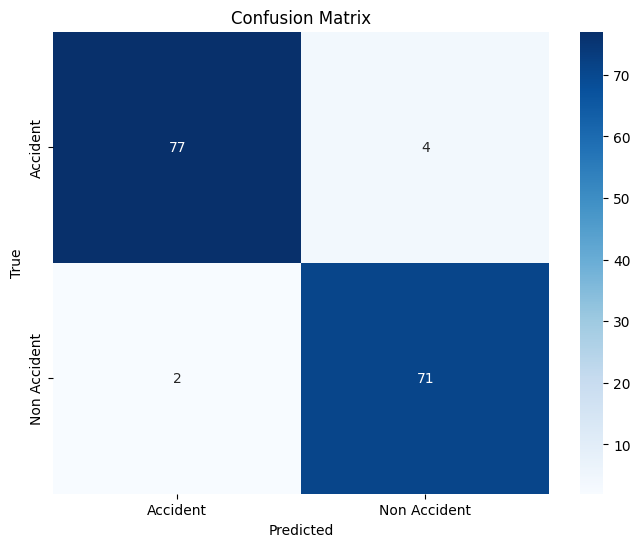


Classification Report:
              precision    recall  f1-score   support

    Accident       0.97      0.95      0.96        81
Non Accident       0.95      0.97      0.96        73

    accuracy                           0.96       154
   macro avg       0.96      0.96      0.96       154
weighted avg       0.96      0.96      0.96       154


Random Predictions for 10 images:
Image: Dashcam Captures Shocking Motorway Pile-Up In Fog - Sajid khan (720p, h264)_frame_58.jpg - Predicted: Non Accident, Actual: Non Accident


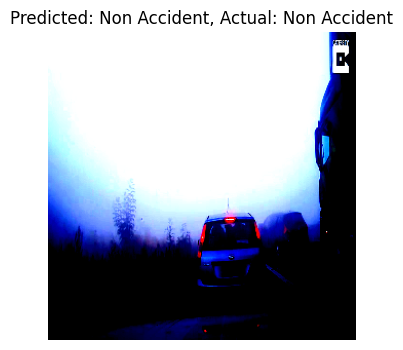

Image: Be careful driving in fog ðŸŒ«ï¸ major car crash #oregon #viral #video we are lucky tha we stay alive ï¿¼ - YOUNGTHUG OAB (720p, h264) (1)_frame_10.jpg - Predicted: Non Accident, Actual: Accident


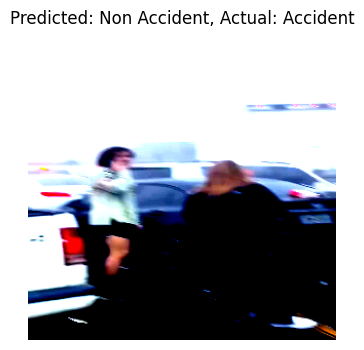

Image: Shocking Mega Motorway Car Pile-Up in Fog I Unstoppable Pile Up I Heavy Fog in Highway - Viral Shorts (720p, h264) (1)_frame_44.jpg - Predicted: Accident, Actual: Accident


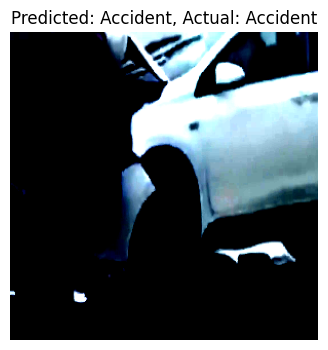

Image: Be careful driving in fog ðŸŒ«ï¸ major car crash #oregon #viral #video we are lucky tha we stay alive ï¿¼ - YOUNGTHUG OAB (720p, h264) (1)_frame_5.jpg - Predicted: Accident, Actual: Accident


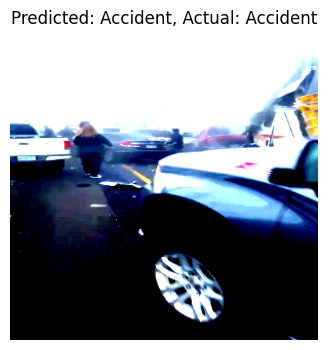

Image: Shocking Mega Motorway Car Pile-Up in Fog I Unstoppable Pile Up I Heavy Fog in Highway - Viral Shorts (720p, h264)_frame_55.jpg - Predicted: Accident, Actual: Accident


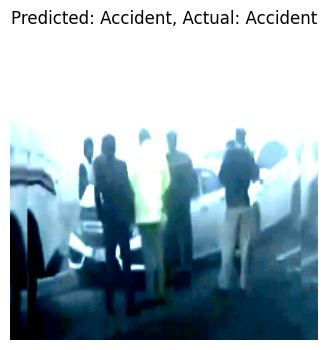

Image: public_20161213_082127_leftImg8bit.png - Predicted: Non Accident, Actual: Non Accident


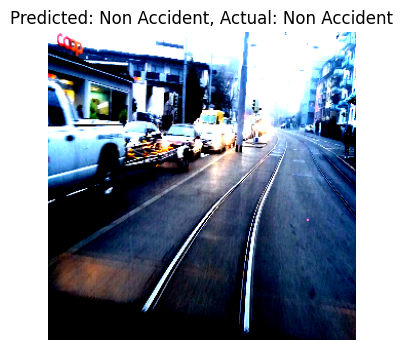

Image: Shocking Mega Motorway Car Pile-Up in Fog I Unstoppable Pile Up I Heavy Fog in Highway - Viral Shorts (720p, h264) (1)_frame_45.jpg - Predicted: Accident, Actual: Accident


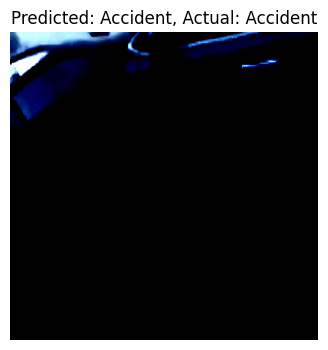

Image: Shocking Mega Motorway Car Pile-Up in Fog I Unstoppable Pile Up I Heavy Fog in Highway - Viral Shorts (720p, h264)_frame_44.jpg - Predicted: Accident, Actual: Accident


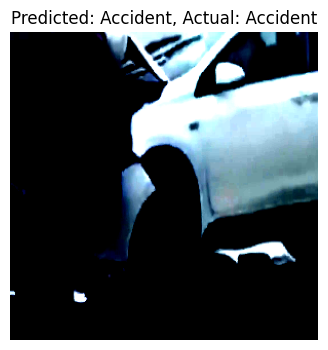

Image: test28_21.jpg - Predicted: Accident, Actual: Accident


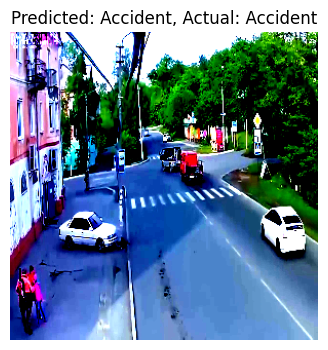

Image: test28_19.jpg - Predicted: Accident, Actual: Accident


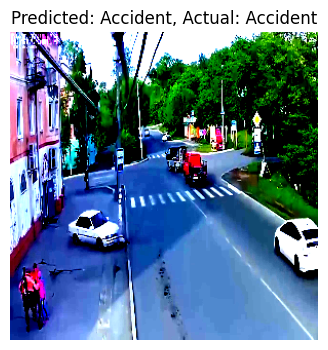

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import os
from torch.utils.data import DataLoader
import cv2
import glob
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.utils.data import Dataset
import numpy as np

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the path to the saved model
project_dir = '/content/drive/MyDrive/foggy_accident_detection/yolo_project'  # Update this path if needed
best_model_path = os.path.join(project_dir, 'best_model.pth')

# Define your custom dataset class if not already defined
class FoggyAccidentDataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentations=None):
        self.root_dir = root_dir
        self.transform = transform
        self.augmentations = augmentations
        self.samples = []
        self.class_to_idx = {'Accident': 0, 'Non Accident': 1}

        for class_name in ['Accident', 'Non Accident']:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: {class_dir} does not exist")
                continue
            for ext in ['*.jpg', '*.jpeg', '*.png']:
                for img_path in glob.glob(os.path.join(class_dir, ext)):
                    self.samples.append((img_path, self.class_to_idx[class_name]))

        print(f"Found {len(self.samples)} images in {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

# Define the test dataset and loader
test_augs = A.Compose([
    A.Resize(300, 300),  # Update image size for EfficientNet-B3
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_dataset = FoggyAccidentDataset(
    root_dir=os.path.join(data_dir, 'test'),
    augmentations=test_augs
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

def evaluate_model(model, test_loader, device, num_samples=10):
    model.eval()
    all_preds = []
    all_labels = []
    image_paths = []
    images = []

    with torch.no_grad():
        for inputs, labels, paths in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            image_paths.extend(paths)
            images.extend(inputs.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Accident', 'Non Accident'], yticklabels=['Accident', 'Non Accident'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Accident', 'Non Accident']))

    # Randomly select a subset of images for display
    indices = np.random.choice(len(image_paths), num_samples, replace=False)
    print(f"\nRandom Predictions for {num_samples} images:")
    for i in indices:
        path = image_paths[i]
        pred = all_preds[i]
        actual = all_labels[i]
        pred_class = 'Accident' if pred == 0 else 'Non Accident'
        actual_class = 'Accident' if actual == 0 else 'Non Accident'
        print(f"Image: {os.path.basename(path)} - Predicted: {pred_class}, Actual: {actual_class}")

        # Display the image
        plt.figure(figsize=(4, 4))
        plt.imshow(images[i].transpose(1, 2, 0))  # Convert from CHW to HWC
        plt.title(f"Predicted: {pred_class}, Actual: {actual_class}")
        plt.axis('off')
        plt.show()

# Ensure the model architecture is defined before loading the state_dict
model = models.efficientnet_b3(weights=None)  # Initialize the model without pre-trained weights
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2)
)
model = model.to(device)

# Load the best model
model.load_state_dict(torch.load(best_model_path))
evaluate_model(model, test_loader, device, num_samples=10)  # Display predictions for 10 random images

In [2]:
import torch
import cv2
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import os
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images in Colab

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the path to the saved model
project_dir = '/content/drive/MyDrive/foggy_accident_detection/yolo_project'  # Update this path if needed
best_model_path = os.path.join(project_dir, 'best_model.pth')

# Ensure the model architecture is defined before loading the state_dict
model = models.efficientnet_b3(weights=None)  # Initialize the model without pre-trained weights
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2)
)
model = model.to(device)

# Load the best model with map_location
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Define the transformation for the video frames
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),  # Resize to match the model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def process_video(video_path, model, device):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to RGB and apply transformations
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_tensor = transform(frame_rgb).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            accident_prob = probabilities[0][0].item()  # Probability of "Accident"

        # Check if the accident probability is greater than or equal to 95%
        if accident_prob >= 0.95 and accident_prob <= 0.96:
            # Overlay the probabilities on the frame
            label = f"Accident: {accident_prob:.2f}"
            cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # Display the frame using cv2_imshow
            cv2_imshow(frame)

        frame_count += 1

    cap.release()

# Path to the external video
video_path = '/content/drive/MyDrive/foggy_accident_detection/testvideo.mp4'  # Update this path to your video file

# Process the video
process_video(video_path, model, device)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/foggy_accident_detection/yolo_project/best_model.pth'

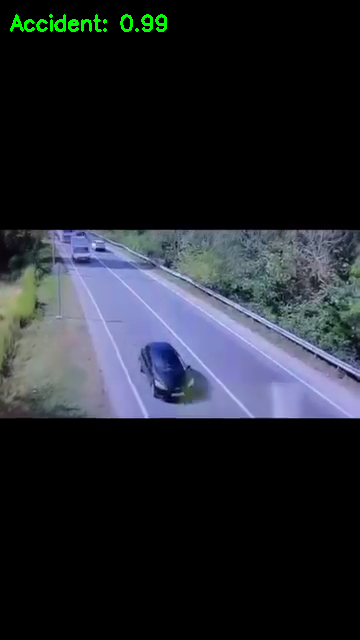

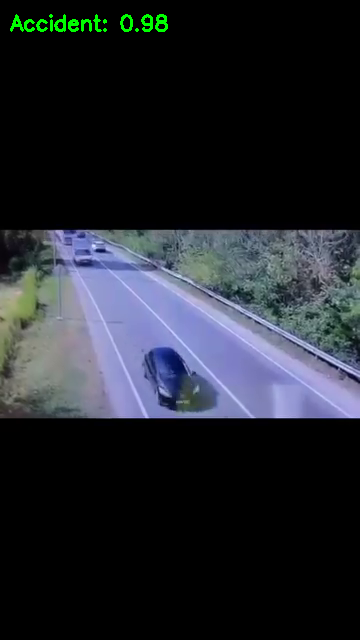

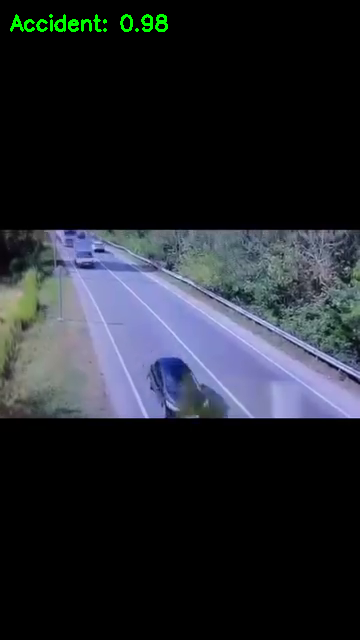

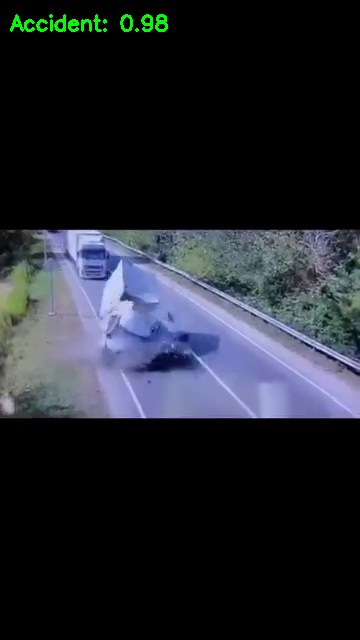

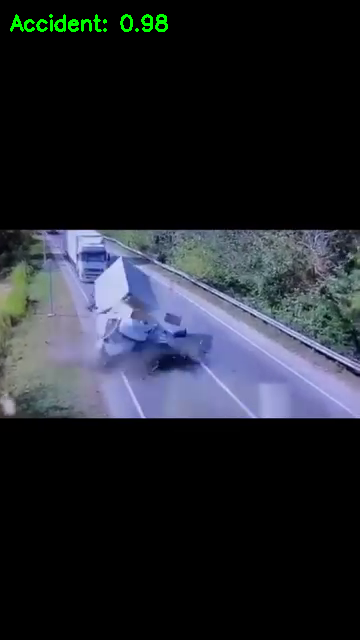

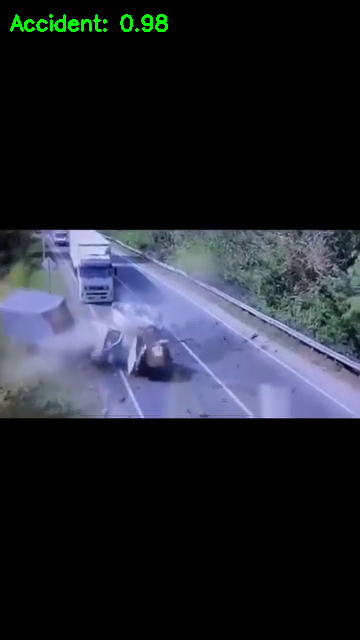

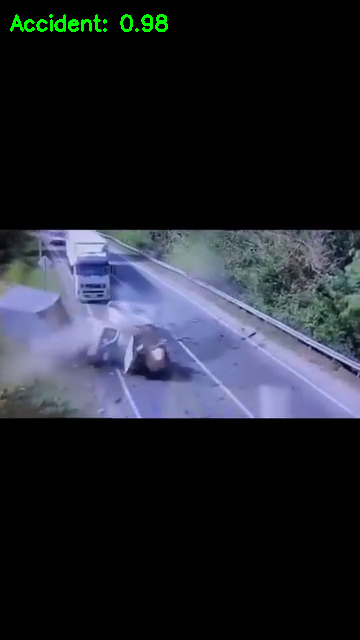

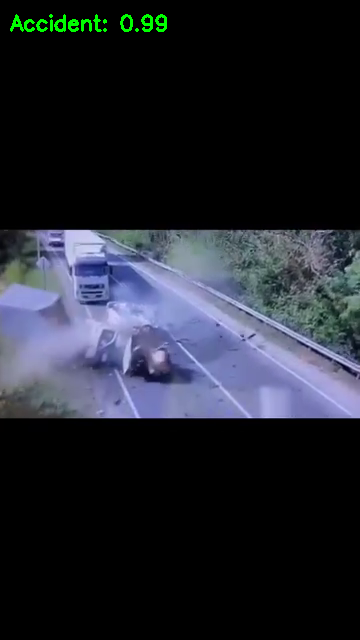

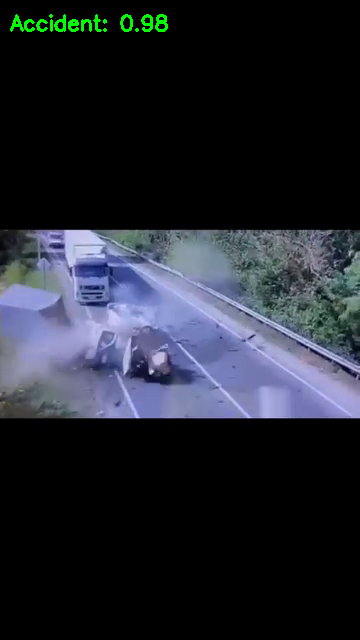

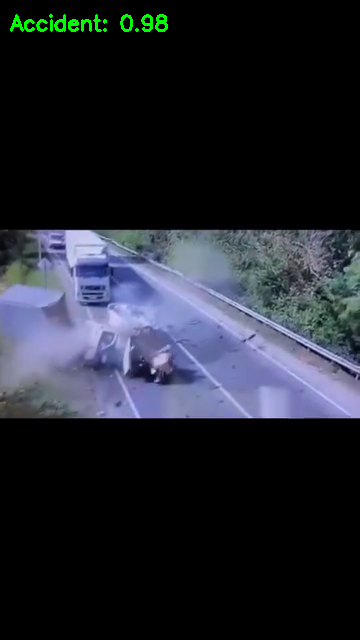

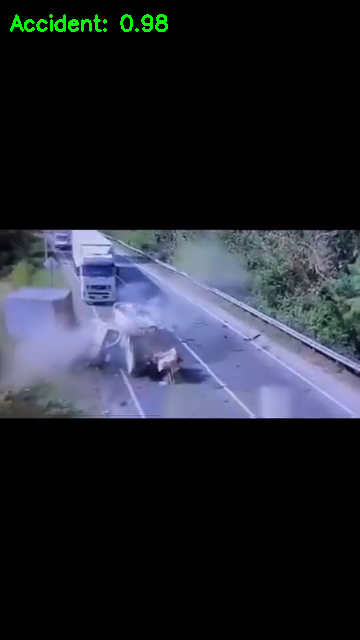

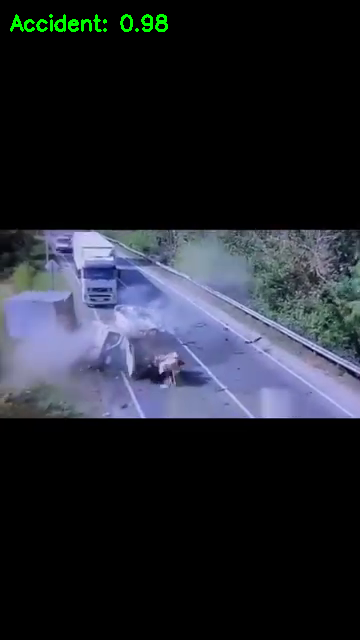

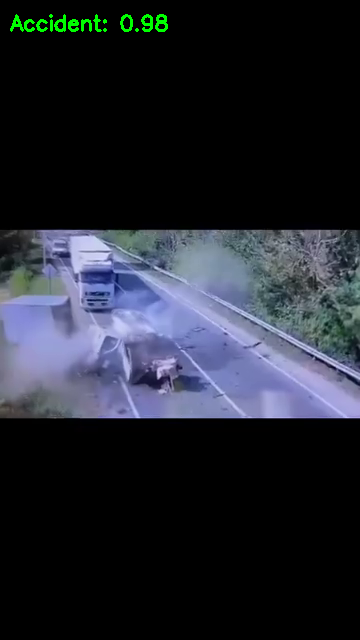

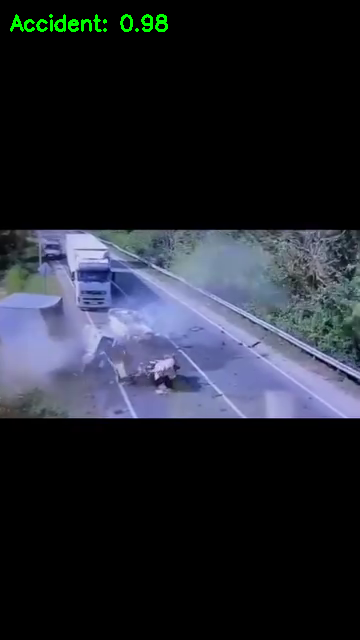

In [ ]:
import torch
import cv2
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import os
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images in Colab

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the path to the saved model
project_dir = '/content/drive/MyDrive/foggy_accident_detection/yolo_project'  # Update this path if needed
best_model_path = os.path.join(project_dir, 'best_model.pth')

# Ensure the model architecture is defined before loading the state_dict
model = models.efficientnet_b3(weights=None)  # Initialize the model without pre-trained weights
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2)
)
model = model.to(device)

# Load the best model with map_location
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Define the transformation for the video frames
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),  # Resize to match the model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def process_video(video_path, model, device):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to RGB and apply transformations
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_tensor = transform(frame_rgb).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            accident_prob = probabilities[0][0].item()  # Probability of "Accident"

        # Check if the accident probability is greater than or equal to 95%
        if accident_prob >= 0.98 and accident_prob != 0.99:
            # Overlay the probabilities on the frame
            label = f"Accident: {accident_prob:.2f}"
            cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # Display the frame using cv2_imshow
            cv2_imshow(frame)

        frame_count += 1

    cap.release()

# Path to the external video
video_path = '/content/drive/MyDrive/foggy_accident_detection/Test.mp4'  # Update this path to your video file

# Process the video
process_video(video_path, model, device)

In [ ]:
from geopy.geocoders import Nominatim
import requests

geolocator = Nominatim(user_agent="myapp_vizag_location_checker")

location = geolocator.geocode("Vizag, Andhra Pradesh, India")

if location:
    print("Address:", location.address)
    print("Latitude:", location.latitude)
    print("Longitude:", location.longitude)
else:
    print("Location not found.")


latitude, longitude = location.latitude, location.longitude
radius = 5000  # meters

# Overpass QL to get hospitals within radius
overpass_query = f"""
[out:json][timeout:25];
(
  node["amenity"="hospital"](around:{radius},{latitude},{longitude});
  way["amenity"="hospital"](around:{radius},{latitude},{longitude});
  rel["amenity"="hospital"](around:{radius},{latitude},{longitude});
);
out center 3;
"""

resp = requests.post(
    "https://overpass-api.de/api/interpreter",
    data={"data": overpass_query}
)
data = resp.json().get("elements", [])[:3]

if not data:
    print(" No hospitals found.")
else:
    print("\n Nearby Hospitals (Overpass):")
    for elem in data:
        tags = elem.get("tags", {})
        name = tags.get("name", "N/A")
        # Get a lat/lon — nodes have .lat/.lon, ways/rels have .center
        if "lat" in elem and "lon" in elem:
            lat, lon = elem["lat"], elem["lon"]
        else:
            lat, lon = elem["center"]["lat"], elem["center"]["lon"]
        print("Name:   ", name)
        print("Coords: ", lat, lon)
        # Optional: construct an address from tags
        addr = ", ".join(filter(None, [
            tags.get("addr:housenumber"),
            tags.get("addr:street"),
            tags.get("addr:city")
        ]))
        if addr:
            print("Address:", addr)
        print()

Address: Visakhapatnam, Visakhapatnam (Urban), Visakhapatnam, Andhra Pradesh, 530001, India
Latitude: 17.6935526
Longitude: 83.2921297

 Nearby Hospitals (Overpass):
Name:    Visakha Homeo Clinic
Coords:  17.7224616 83.3094001

Name:    Sri Venkateshwara Nursing Hospital
Coords:  17.7147802 83.307414

Name:    Amulya Hospitals
Coords:  17.7154685 83.3086985
Address: Nowroji Street, visakhapatnam



In [ ]:
!pip install twilio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.7 MB/s eta 0:00:00


In [ ]:
from twilio.rest import Client

# Twilio credentials
account_sid = 'ACa64abae95f92af1097709024063da40a'
auth_token = '1c6236e795eaf758558ea46e65b080c7'

# Initialize the client
client = Client(account_sid, auth_token)

location_link = f"https://maps.google.com/?q={latitude},{longitude}"
message_text = f" Emergency! Accident detected near: {location_link}"

# Send the message
message = client.messages.create(
    from_='+12177637020',
    body=message_text,
    to='+919121392956'
)

print("Sent emergency message:", message.sid)

Sent emergency message: SMcfdaa9e662d2176bfd87623a163b4ce8
